### Import Libraries

In [149]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy # A module that provides functions for creating copies of objects, useful for avoiding unintended modifications to variables.
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchsummary import summary
import torch.nn.functional as F
import pathlib
import splitfolders
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')
# import packages 
from sklearn.model_selection import train_test_split 

In [150]:
# Checking GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU...')
else:
    print('Training on GPU...')

Training on GPU...


In [151]:
df = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv') # will test our model on this 
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
df.values[:, 1:][0].reshape((-1,28, 28)).shape

(1, 28, 28)

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 42000 entries, 0 to 41999

Columns: 785 entries, label to pixel783

dtypes: int64(785)

memory usage: 251.5 MB


In [155]:
df.label.value_counts() # unbalanced datasets # 10 labels

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [156]:
df.shape # shows pic is 28*28 matrix or pixels

(42000, 785)

In [157]:
train_set, test_set= train_test_split(df, random_state=104, test_size=0.20, shuffle=True) 
train_set.shape

(33600, 785)

In [158]:
train_set.label.value_counts()

label
1    3754
7    3556
3    3515
2    3350
9    3334
6    3276
4    3272
8    3271
0    3235
5    3037
Name: count, dtype: int64

In [159]:
# RandomOverSampler will make copies of datapoints to make it balanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=104)
train_images, train_labels  = ros.fit_resample(train_set.values[:, 1:], train_set.label.values)
test_images, test_labels  = ros.fit_resample(test_set.values[:, 1:], test_set.label.values)

In [160]:
unique_values = np.unique(train_labels)
# Count occurrences of each unique value
counts = np.bincount(train_labels)
# Print results
print("Unique values:", unique_values)
print("Counts:", counts)
unique_values = np.unique(test_labels)
# Count occurrences of each unique value
counts = np.bincount(test_labels)
# Print results
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1 2 3 4 5 6 7 8 9]

Counts: [3754 3754 3754 3754 3754 3754 3754 3754 3754 3754]

Unique values: [0 1 2 3 4 5 6 7 8 9]

Counts: [930 930 930 930 930 930 930 930 930 930]


In [161]:
# train_images.reshape(-1,1,28,28)[0]# 1 is color chnnael and -1 menans ki haar row ma perform krr(1,28,28) otherwise write train_images[0].reshape(1,28,28)

In [162]:
def load_data(train_images, train_labels, test_images, test_labels):
    train_images = train_images.reshape((-1,1,28, 28))
    train_images = torch.tensor(train_images)
    print(train_images.shape) #torch.Size([42000, 1, 28, 28])
    
    train_labels = train_labels.reshape(train_labels.shape[0], 1)
    train_labels = torch.tensor(train_labels)
    train_labels = train_labels.view(-1) # change to 1 D array
    print(train_labels.shape) #torch.Size([42000, 1])
    
    test_images = test_images.reshape((-1,1, 28, 28))
    test_images = torch.tensor(test_images)
    print(test_images.shape) 
    
    test_labels = test_labels.reshape(test_labels.shape[0], 1)
    test_labels = torch.tensor(test_labels)
    test_labels = test_labels.view(-1)
    print(test_labels.shape) 
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = load_data(train_images, train_labels, test_images, test_labels)

torch.Size([37540, 1, 28, 28])

torch.Size([37540])

torch.Size([9300, 1, 28, 28])

torch.Size([9300])


In [163]:
# train_images, train_labels, test_images, test_labels

In [1]:
# train_images[0], train_labels[0] #3D image

# Before transformation images 

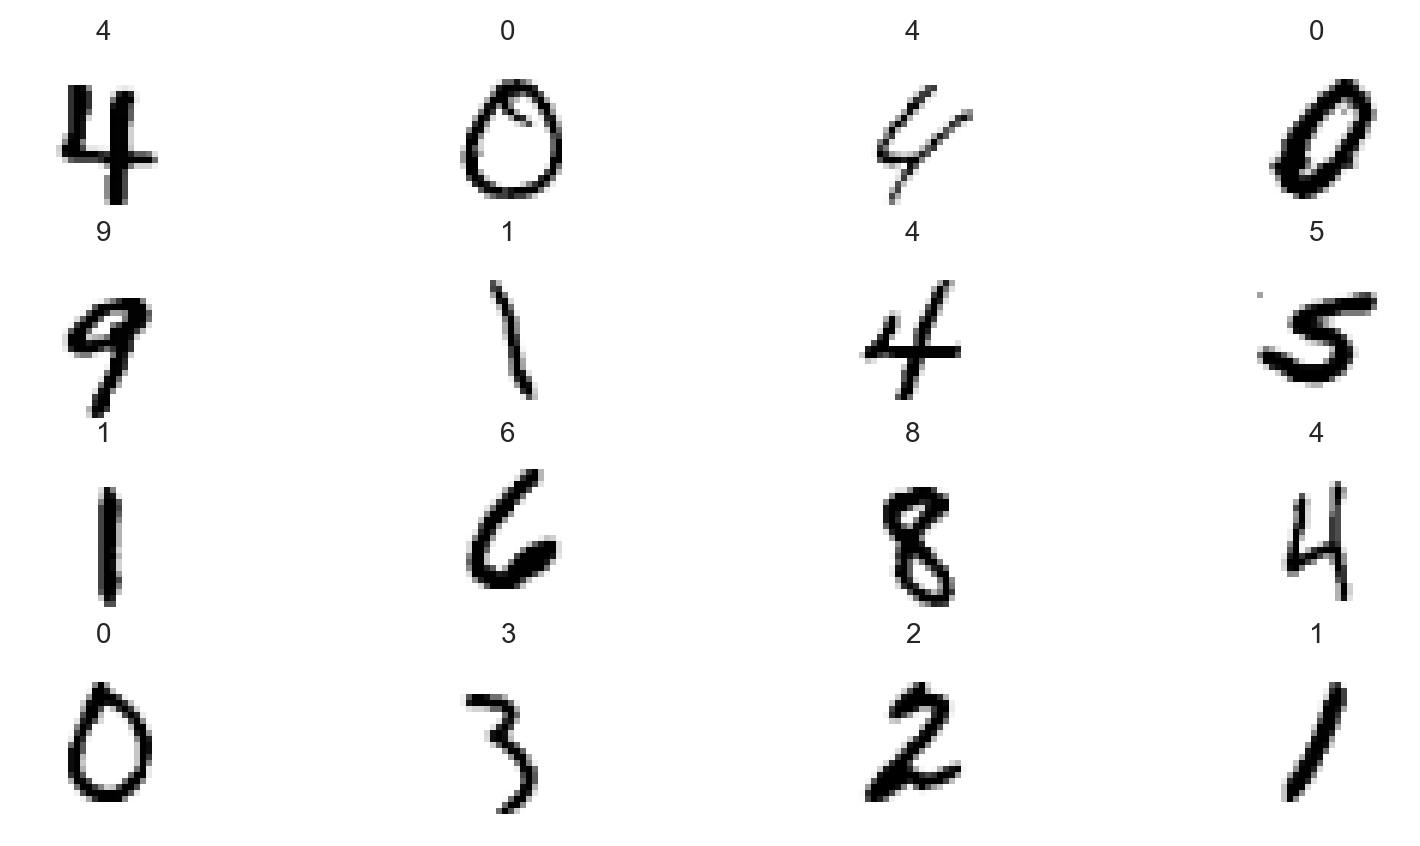

In [165]:
import matplotlib.pyplot as plt
import numpy as np


rows = 4
cols = 4

fig, axs = plt.subplots(rows, cols, figsize=(10, 5))  # Create a figure with subplots
for i in range(0,rows*cols):
    image = train_images[i].cpu().permute(1, 2, 0)  # Permute image axes if necessary
    label = train_labels[i]
    ax = axs[i // cols, i % cols]  # Get the subplot for the current image
    #print(i // cols,  i % cols)
    ax.imshow(image, cmap='binary')  # Display the image
    ax.set_title(label.item(), fontsize=10)  # Show label as the title of the subplot
    ax.axis("off")  # Remove axes


In [166]:
# define transformation
transform_train = transforms.Compose(
    [
        transforms.ToPILImage(),
        #transforms.RandomHorizontalFlip(p=0.25), ## make more tough to recognize a image which also effects the accuracy of model 
        #transforms.RandomVerticalFlip(p=0.25), 
        #transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485,), std=(0.229,))

   ]
)
# define transformation
transform_test = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485,), std=(0.229,))

   ]
)

In [167]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [168]:
batch_size = 100

In [169]:
train_dataset = CustomTensorDataset(tensors=(train_images.float(), train_labels.long()), transform=transform_train)
test_dataset = CustomTensorDataset(tensors=(test_images.float(), test_labels.long()), transform=transform_test)
train_img_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size)
test_img_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size)

In [2]:
# train_dataset[0], test_dataset[0]

In [171]:
for x,y in train_img_loader:
    print(x,y)
    break

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          ...,

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]]],





        [[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          ...,

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]]],





        [[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

       

In [172]:
images, labels = next(iter(train_img_loader))
for image, labels in train_img_loader:
    print(labels)
    break
images.shape

tensor([4, 0, 4, 0, 9, 1, 4, 5, 1, 6, 8, 4, 0, 3, 2, 1, 7, 8, 3, 9, 5, 4, 3, 1,

        3, 1, 9, 2, 8, 5, 2, 1, 7, 9, 7, 7, 0, 7, 6, 3, 3, 5, 6, 3, 8, 0, 9, 2,

        7, 4, 8, 9, 4, 8, 9, 4, 8, 2, 2, 5, 4, 2, 4, 9, 8, 4, 3, 8, 9, 2, 4, 5,

        1, 6, 8, 3, 9, 1, 0, 6, 6, 3, 0, 8, 6, 1, 9, 6, 1, 7, 1, 6, 3, 1, 0, 8,

        4, 0, 2, 2])


torch.Size([100, 1, 28, 28])

In [173]:
labels[:10]

tensor([4, 0, 4, 0, 9, 1, 4, 5, 1, 6])

# After transformation images

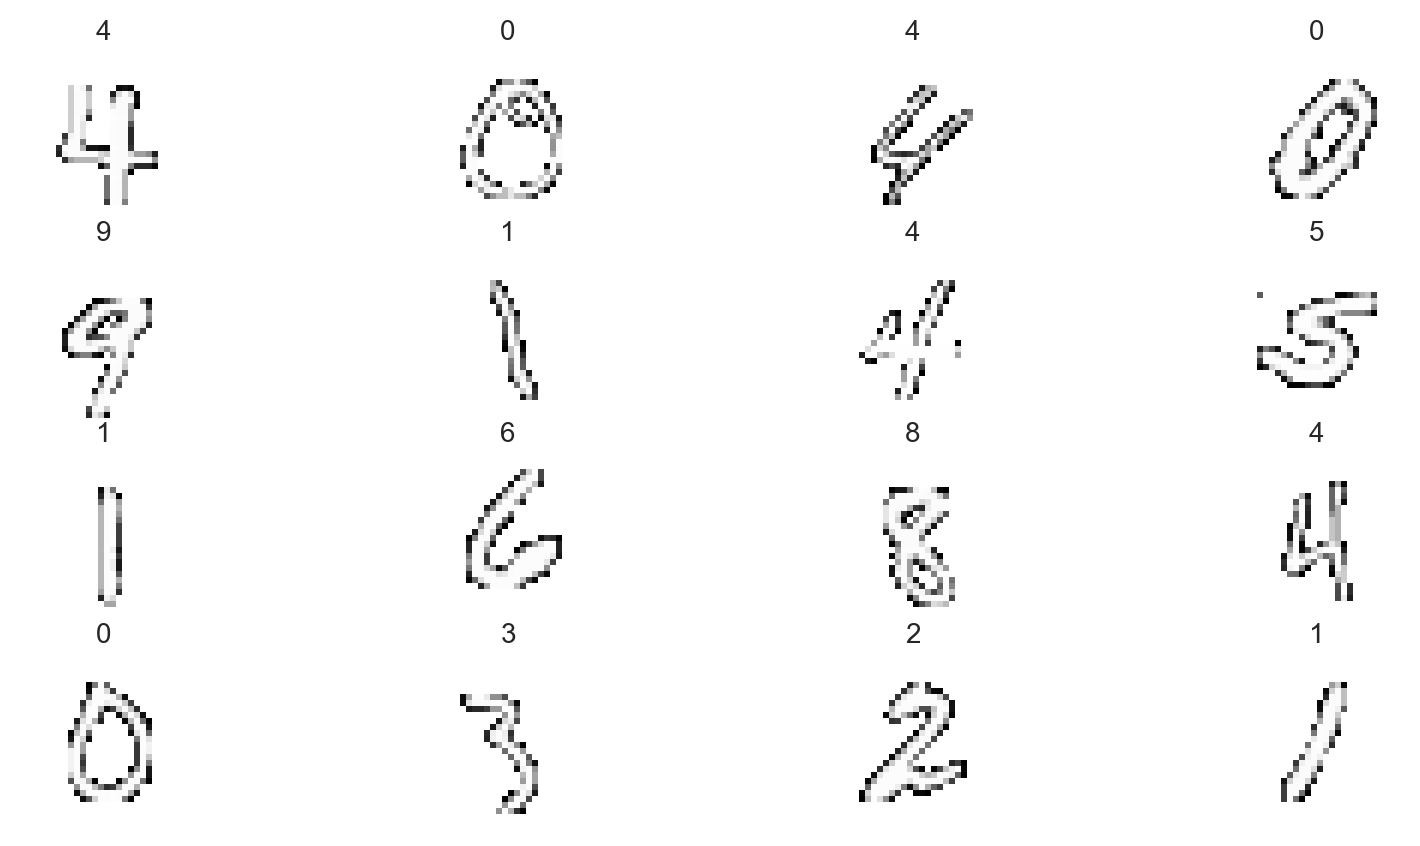

In [174]:
import matplotlib.pyplot as plt
import numpy as np


rows = 4
cols = 4

fig, axs = plt.subplots(rows, cols, figsize=(10, 5))  # Create a figure with subplots
for i in range(0,rows*cols):
    image = images[i].cpu().permute(1, 2, 0)  # Permute image axes if necessary
    label = labels[i]
    ax = axs[i // cols, i % cols]  # Get the subplot for the current image
    #print(i // cols,  i % cols)
    ax.imshow(image, cmap='binary')  # Display the image
    ax.set_title(label.item(), fontsize=10)  # Show label as the title of the subplot
    ax.axis("off")  # Remove axes


In [123]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128*2, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128*2),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(1*1*128*2, 10), #if accuracy is still not ok increase number of hidden layers
        )
                
        
    def forward(self, x):
        #print(x.shape)# torch.Size([2, 1, 28, 28]) got two convo layers so divide by two then again divide by 2
        
        x = self.conv1(x)
        #print(x.shape)#torch.Size([2, 32, 7, 7])
        
        x = self.conv2(x)
        #print(x.shape)#torch.Size([2, 64, 2, 2])
        
        x = self.conv3(x)
        #print(x.shape)#torch.Size([2, 128, 1, 1])
        
        
        x = x.view(x.size(0), -1)
        #print(x.shape)#torch.Size([2, 128])
        
        return self.fc(x)

model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(

  (conv1): Sequential(

    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (1): ReLU()

    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

    (4): ReLU()

    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    (7): Dropout(p=0.25, inplace=False)

  )

  (conv2): Sequential(

    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    (1): ReLU()

    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

    (4): ReLU()

    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [124]:
LEARNING_RATE = 0.001680

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [125]:
# Model Summary for CNN Model
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1           [-1, 64, 28, 28]             640

              ReLU-2           [-1, 64, 28, 28]               0

       BatchNorm2d-3           [-1, 64, 28, 28]             128

            Conv2d-4           [-1, 64, 14, 14]          36,928

              ReLU-5           [-1, 64, 14, 14]               0

       BatchNorm2d-6           [-1, 64, 14, 14]             128

         MaxPool2d-7             [-1, 64, 7, 7]               0

           Dropout-8             [-1, 64, 7, 7]               0

            Conv2d-9            [-1, 128, 7, 7]          73,856

             ReLU-10            [-1, 128, 7, 7]               0

      BatchNorm2d-11            [-1, 128, 7, 7]             256

           Conv2d-12            [-1, 128, 4, 4]         147,584

             ReLU-13            [-1, 128, 4, 4]               0

      BatchNorm2d-14   

In [126]:
epochs = 150
valid_loss_min = np.Inf
train_losses, valid_losses = [], []
history_accuracy = []

for e in range(1, epochs+1):
    running_loss = 0

    for images, labels in train_img_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # Clear the gradients, do this because gradients are accumulated.
        optimizer.zero_grad()
        
        # Forward pass, get our log-probabilities.
        ps = model(images)
        # Calculate the loss with the logps and the labels.
        loss = criterion(ps, labels)
        
        # Turning loss back.
        loss.backward()
        
        # Take an update step and few the new weights.
        optimizer.step()
        
        running_loss += loss.item()
    else:
        valid_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations.
        with torch.no_grad():
            model.eval() # change the network to evaluation mode
            for images, labels in test_img_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                # Forward pass, get our log-probabilities.
                #log_ps = model(images)
                ps = model(images)
                
                # Calculating probabilities for each class.
                #ps = torch.exp(log_ps)
                
                # Capturing the class more likely.
                _, top_class = ps.topk(1, dim=1)
                
                # Verifying the prediction with the labels provided.
                equals = top_class == labels.view(*top_class.shape)
                
                valid_loss += criterion(ps, labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train() # change the network to training mode
        
        train_losses.append(running_loss/len(train_img_loader))
        valid_losses.append(valid_loss/len(test_img_loader))
        history_accuracy.append(accuracy/len(test_img_loader))
        
        network_learned = valid_loss < valid_loss_min

        if e == 1 or e % 5 == 0 or network_learned:
            print(f"Epoch: {e}/{epochs}.. ",
                  f"Training Loss: {running_loss/len(train_img_loader):.3f}.. ",
                  f"Validation Loss: {valid_loss/len(test_img_loader):.3f}.. ",
                  f"Test Accuracy: {accuracy/len(test_img_loader):.3f}")
        
        if network_learned:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'model_mtl_mnist.pt')
            print('Detected network improvement, saving current model')

Epoch: 1/150..  Training Loss: 1.775..  Validation Loss: 0.910..  Test Accuracy: 0.702

Detected network improvement, saving current model

Epoch: 2/150..  Training Loss: 0.963..  Validation Loss: 0.475..  Test Accuracy: 0.845

Detected network improvement, saving current model

Epoch: 3/150..  Training Loss: 0.701..  Validation Loss: 0.323..  Test Accuracy: 0.896

Detected network improvement, saving current model

Epoch: 4/150..  Training Loss: 0.588..  Validation Loss: 0.247..  Test Accuracy: 0.920

Detected network improvement, saving current model

Epoch: 5/150..  Training Loss: 0.521..  Validation Loss: 0.203..  Test Accuracy: 0.938

Detected network improvement, saving current model

Epoch: 6/150..  Training Loss: 0.480..  Validation Loss: 0.172..  Test Accuracy: 0.947

Detected network improvement, saving current model

Epoch: 7/150..  Training Loss: 0.440..  Validation Loss: 0.153..  Test Accuracy: 0.953

Detected network improvement, saving current model

Epoch: 8/150..  Trai

In [176]:
valid_losseses = []
for loss in valid_losses:
    valid_losseses.append(loss.item())

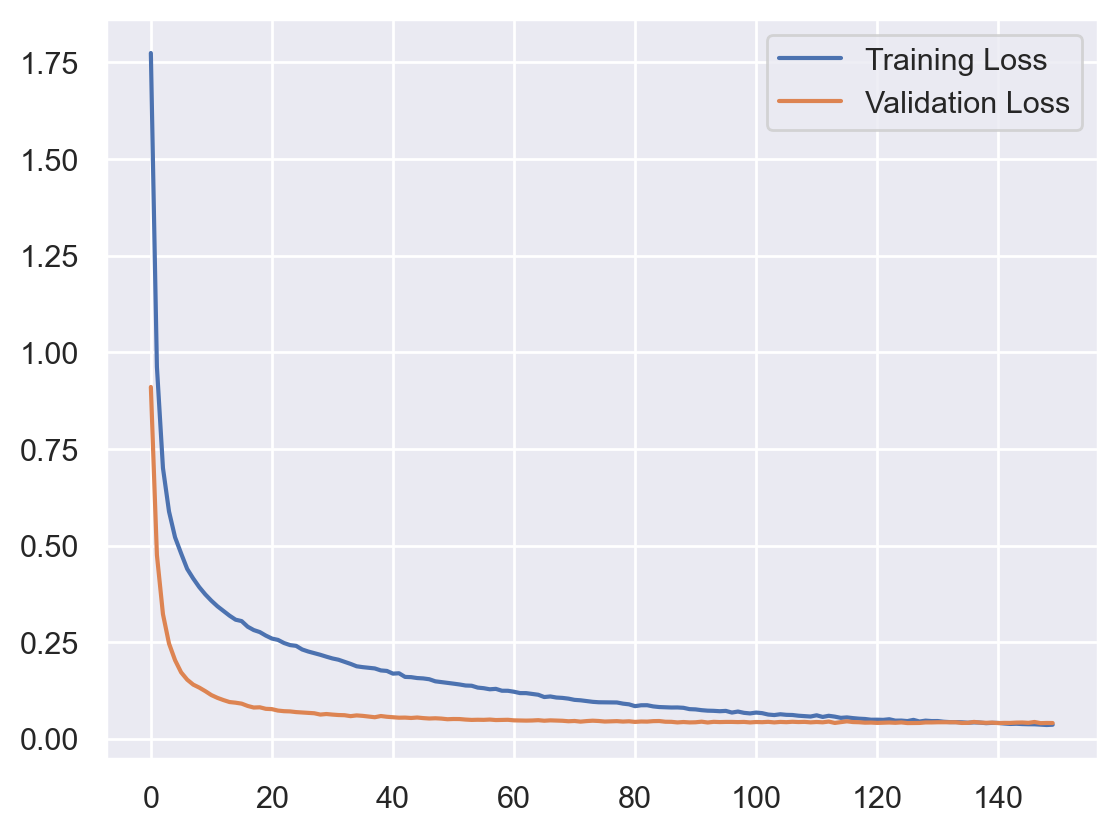

In [177]:
# Viewing training information
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losseses, label='Validation Loss')
plt.legend(frameon=True)


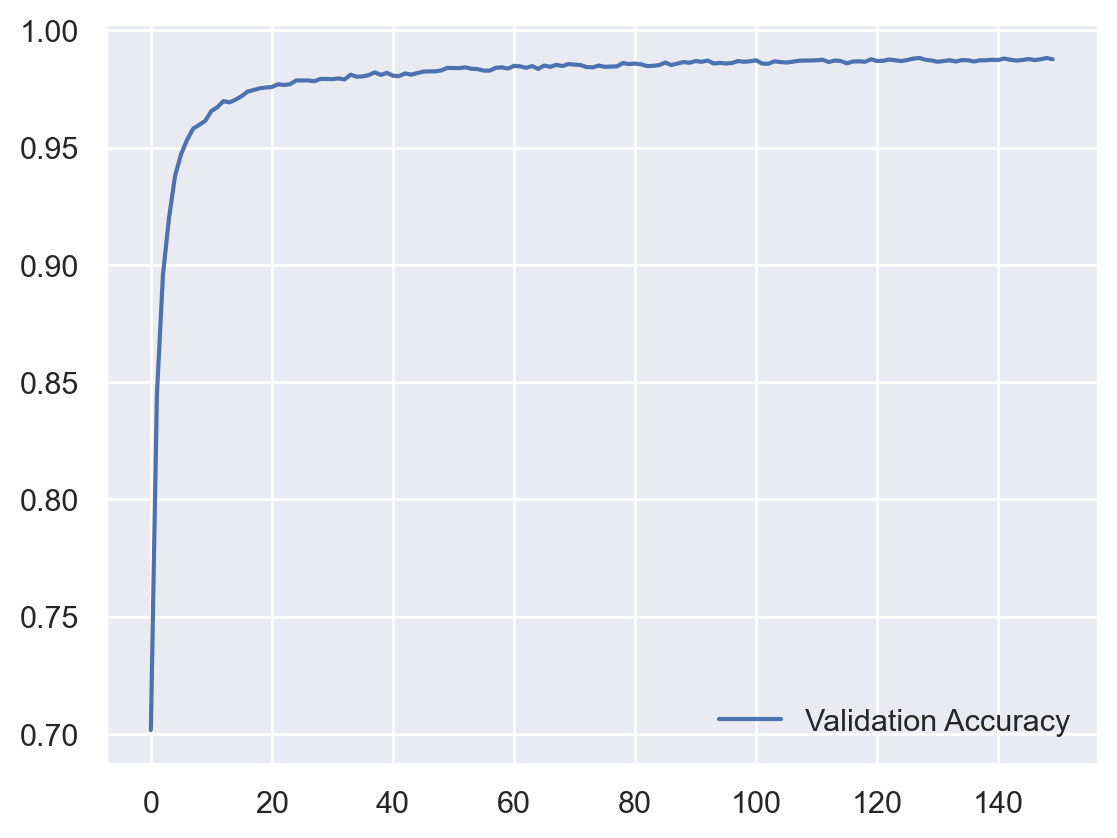

In [178]:
plt.plot(history_accuracy, label='Validation Accuracy')
plt.legend(frameon=False)

In [180]:
updated_test_img_loader = torch.utils.data.DataLoader(test_dataset, batch_size= len(test_dataset))
len(updated_test_img_loader)

1

In [184]:
model = model.cpu()
predicted = []
true =[]
with torch.no_grad():
    model.eval() # change the network to evaluation mode
    for images, labels in updated_test_img_loader:
        images, labels = images.cpu(), labels.cpu()
        ps = model(images)
        pred = torch.max(ps.data, 1)[1]
        for x in pred:
            predicted.append(x.item()) 
        for x in labels:
            true.append(x.item()) 


In [185]:
count=0
for x in range(len(predicted)):
    if predicted[x]==true[x]:
        count+=1
(count/len(predicted))*100

98.76344086021506

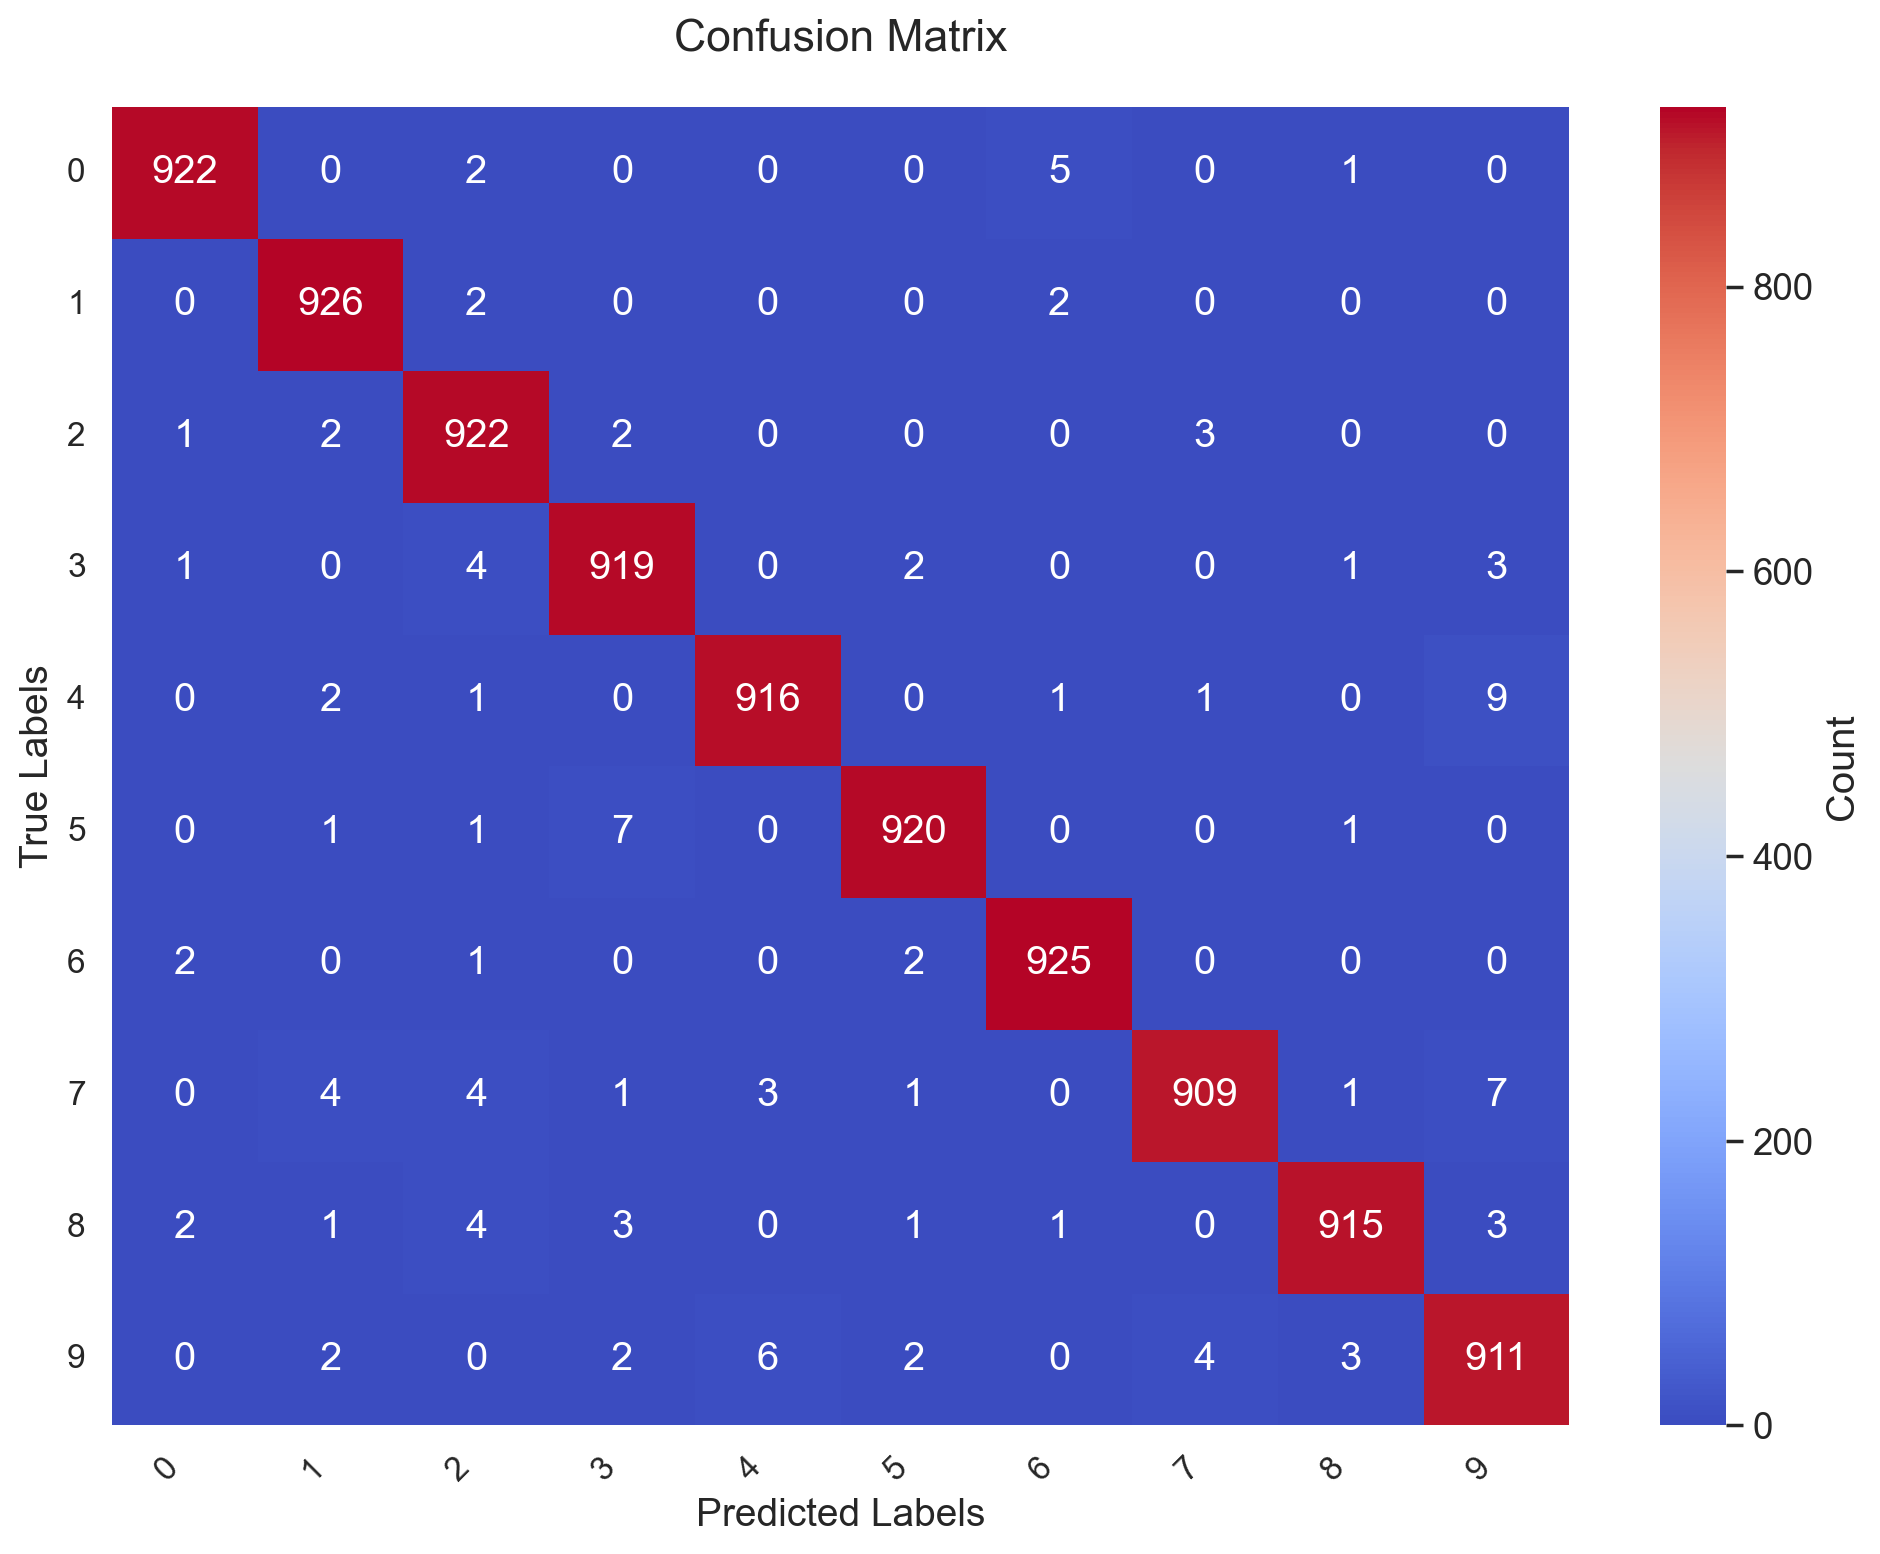

In [186]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute confusion matrix
cm = confusion_matrix(true, predicted)

# Plot confusion matrix with enhanced visuals
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Increase the font scale for better readability
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm', cbar_kws={'label': 'Count'})

# Set axis labels
ax.set_xlabel('Predicted Labels', fontsize=14)
ax.set_ylabel('True Labels', fontsize=14)

# Set tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

# Set title
ax.set_title('Confusion Matrix', fontsize=16, pad=20)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# Loading Test datset 


In [187]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
df_test.shape

(28000, 784)

In [189]:
def load_data(test_images):
    test_images = test_images.reshape((-1,1,28, 28))
    test_images = torch.tensor(test_images)
    print(test_images.shape) 
    return test_images

test_images= load_data(df_test.values)
test_images= test_images.float()

torch.Size([28000, 1, 28, 28])


In [190]:
len(test_images)

28000

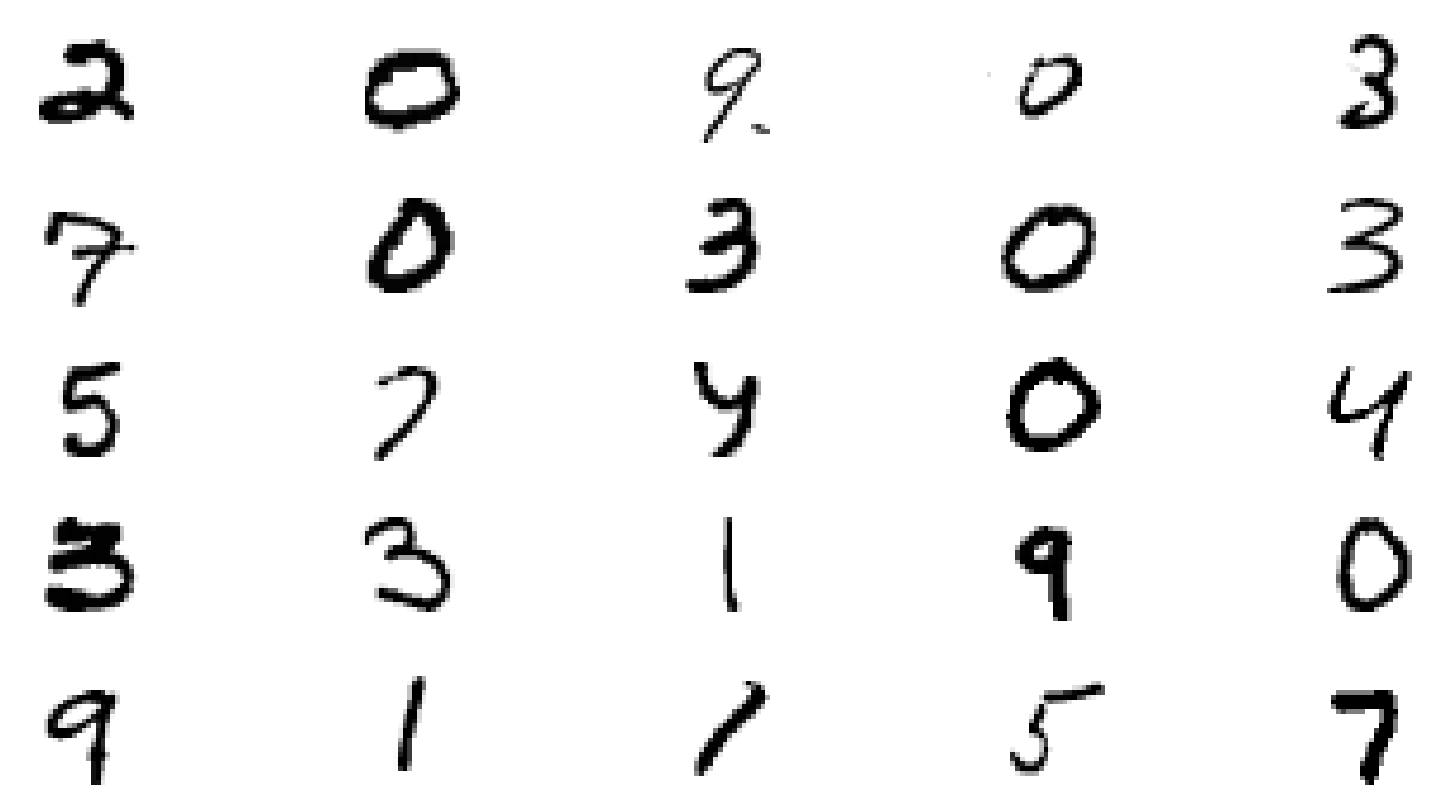

In [191]:
rows = 5
cols = 5

fig, axs = plt.subplots(rows, cols, figsize=(10, 5))  # Create a figure with subplots
for i in range(0,rows*cols):
    image = test_images[i].cpu().permute(1, 2, 0)  # Permute image axes if necessary
    ax = axs[i // cols, i % cols]  # Get the subplot for the current image
    ax.imshow(image, cmap='binary')  # Display the image
    ax.axis("off")  # Remove axes
    

In [192]:
import torch
from torch.utils.data import Dataset

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms for a single tensor."""
    
    def __init__(self, tensor, transform=None):
        assert isinstance(tensor, torch.Tensor), "Input must be a single tensor."
        self.tensor = tensor
        self.transform = transform

    def __getitem__(self, index):
        sample = self.tensor[index]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

    def __len__(self):
        return self.tensor.size(0)



In [193]:
test_dataset = CustomTensorDataset(tensor=test_images, transform=transform_test)

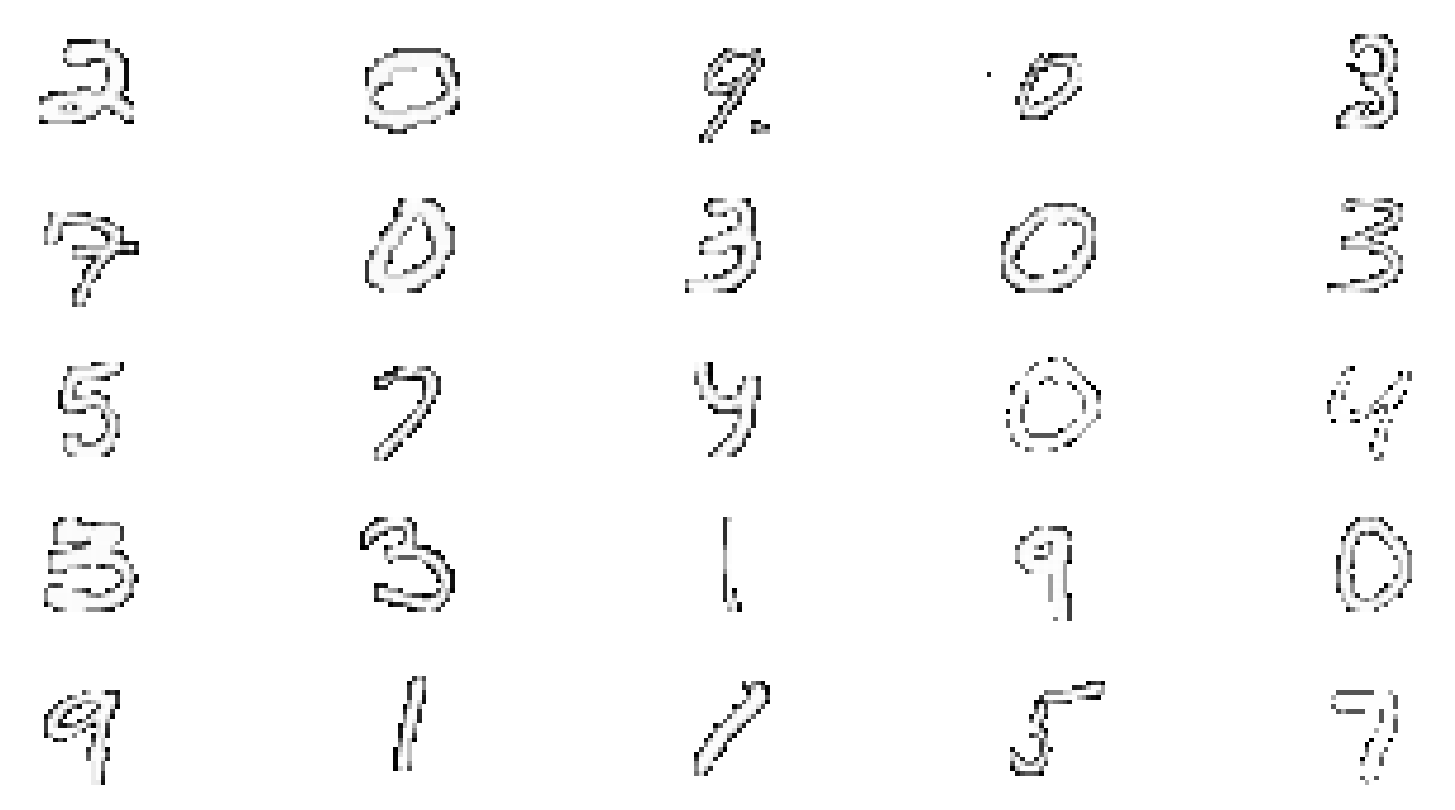

In [195]:
rows = 5
cols = 5

fig, axs = plt.subplots(rows, cols, figsize=(10, 5))  # Create a figure with subplots
for i in range(0,rows*cols):
    image = test_dataset[i].cpu().permute(1, 2, 0)  # Permute image axes if necessary
    ax = axs[i // cols, i % cols]  # Get the subplot for the current image
    ax.imshow(image, cmap='binary')  # Display the image
    ax.axis("off")  # Remove axes


In [3]:
# for images in test_dataset:
#     print(images.reshape(-1,1,28,28))
#     break

In [197]:
if train_on_gpu:
    model.load_state_dict(torch.load('model_mtl_mnist.pt'))
    model = model.cuda()
label = []
ImageId=[]
with torch.no_grad():
    model.eval() # change the network to evaluation mode
    for Id, images in enumerate(test_dataset):
        images = images.reshape(-1,1,28,28).cuda()
        output = model(images)
        pred = torch.max(output.data, 1)[1]
        label.append(pred.item())
        ImageId.append(Id)


In [198]:
len(ImageId), len(label)

(28000, 28000)

In [199]:
import csv

assert len(ImageId) == len(label) #"The length of ImageId and labels must be the same."

# File name
file_name = 'test_submission_csv.csv'

# Writing to CSV
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ImageId', 'Label'])  # Write header
    writer.writerows(zip(range(1, len(ImageId) + 1), label)) 

print(f"Data written to {file_name} successfully.")


Data written to test_submission_csv.csv successfully.
